In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random
from torch.utils.data import DataLoader, SubsetRandomSampler

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

# Define dataset root directory
mnist_root = '/home/j597s263/scratch/j597s263/Datasets/MNIST'

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root=mnist_root, transform=transform, train=True, download=True)
test_dataset = datasets.MNIST(root=mnist_root, transform=transform, train=False, download=True)

train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)  

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)  # Shuffle within batches
attack_loader = DataLoader(attack_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Total training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

Total training samples: 60000
Training samples after split: 54000
Attack samples: 6000
Testing samples: 10000


In [3]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [4]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Resnet/Base/ResMNIBase.mod', weights_only=False, map_location="cuda:0")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [8]:
import numpy as np
import matplotlib.pyplot as plt

lime_explanations = np.load('/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Resnet/LimeMNI.npy', allow_pickle=True)

print(f"Number of explanations: {len(lime_explanations)}")
print(f"Example explanation: {lime_explanations[0]}")

Number of explanations: 6000
Example explanation: {'index': 0, 'label': 7, 'mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}


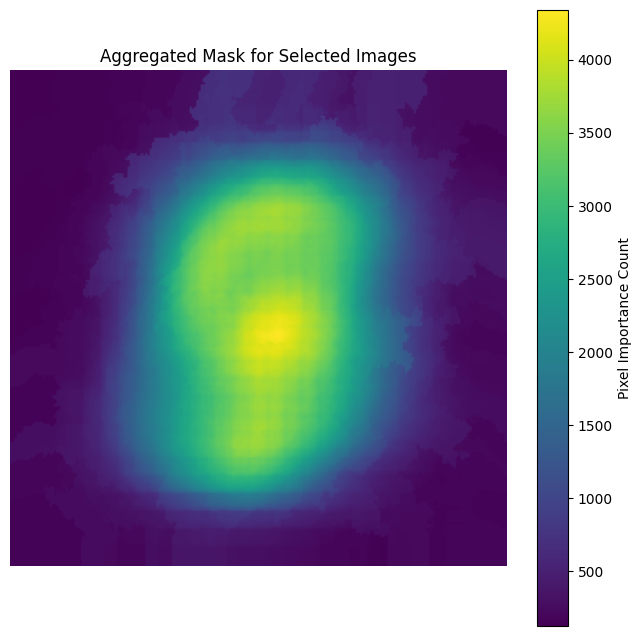

Aggregated Mask Summary:
Shape: (224, 224)
Unique Values: [ 125  127  128 ... 4333 4334 4342]


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Indices of the selected images
selected_indices = list(range(len(lime_explanations)))  

# Initialize an empty array for aggregation
aggregated_mask = np.zeros_like(lime_explanations[0]['mask'], dtype=int)

# Sum the masks for the selected indices
for i in selected_indices:
    explanation = lime_explanations[i]
    mask = explanation['mask']  # Get the mask for the explanation
    aggregated_mask += mask  # Add the mask to the aggregated array

# Visualize the aggregated mask
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_mask, cmap='viridis')  # Use a color map to highlight intensity
plt.title("Aggregated Mask for Selected Images")
plt.colorbar(label="Pixel Importance Count")
plt.axis('off')
plt.show()

# Print summary
print("Aggregated Mask Summary:")
print(f"Shape: {aggregated_mask.shape}")
print(f"Unique Values: {np.unique(aggregated_mask)}")


In [10]:
# Flatten the aggregated mask and get the indices of the top 22 values
flattened_mask = aggregated_mask.flatten()
top_22_indices = np.argsort(flattened_mask)[-22:][::-1]  # Indices of top 22 values, sorted in descending order

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_mask.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixel coordinates and their values
print("Top 22 Pixel Locations and Their Values:")
for coord in top_22_coords:
    pixel_value = aggregated_mask[coord]
    print(f"Pixel {coord}: Value {pixel_value}")


Top 22 Pixel Locations and Their Values:
Pixel (np.int64(120), np.int64(121)): Value 4342
Pixel (np.int64(119), np.int64(121)): Value 4334
Pixel (np.int64(120), np.int64(120)): Value 4333
Pixel (np.int64(119), np.int64(122)): Value 4325
Pixel (np.int64(119), np.int64(120)): Value 4325
Pixel (np.int64(121), np.int64(121)): Value 4322
Pixel (np.int64(120), np.int64(122)): Value 4321
Pixel (np.int64(121), np.int64(120)): Value 4320
Pixel (np.int64(118), np.int64(120)): Value 4317
Pixel (np.int64(119), np.int64(119)): Value 4315
Pixel (np.int64(120), np.int64(119)): Value 4312
Pixel (np.int64(118), np.int64(121)): Value 4309
Pixel (np.int64(120), np.int64(118)): Value 4308
Pixel (np.int64(119), np.int64(118)): Value 4305
Pixel (np.int64(118), np.int64(119)): Value 4304
Pixel (np.int64(121), np.int64(119)): Value 4301
Pixel (np.int64(120), np.int64(117)): Value 4296
Pixel (np.int64(118), np.int64(122)): Value 4294
Pixel (np.int64(117), np.int64(120)): Value 4290
Pixel (np.int64(121), np.int

In [11]:

import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ResLimeMni"
os.makedirs(output_dir, exist_ok=True)

top_22_coords = [
    (120, 121), (119, 121), (120, 120), (119, 122), (119, 120),
    (121, 121), (120, 122), (121, 120), (118, 120), (119, 119),
    (120, 119), (118, 121), (120, 118), (119, 118), (118, 119),
    (121, 119), (120, 117), (118, 122), (117, 120), (121, 122),
    (122, 120), (117, 121)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone() 

    for img_idx, image_tensor in enumerate(batch_images):
        for x, y in top_22_coords:
            if 0 <= x < image_tensor.size(1) and 0 <= y < image_tensor.size(2):  
                image_tensor[:, x, y] = 0  

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * batch_images.size(0) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/24
Processed batch 2/24
Processed batch 3/24
Processed batch 4/24
Processed batch 5/24
Processed batch 6/24
Processed batch 7/24
Processed batch 8/24
Processed batch 9/24
Processed batch 10/24
Processed batch 11/24
Processed batch 12/24
Processed batch 13/24
Processed batch 14/24
Processed batch 15/24
Processed batch 16/24
Processed batch 17/24
Processed batch 18/24
Processed batch 19/24
Processed batch 20/24
Processed batch 21/24
Processed batch 22/24
Processed batch 23/24
Processed batch 24/24
Modified images saved to /home/j597s263/scratch/j597s263/Datasets/Attack/ResLimeMni
